In [1]:
# import numpy
import numpy as np

# import Markdown for nice display
from IPython.display import Markdown, display

# import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# import defaultdict (we'll use this instead of dict because it allows us to initialize a dictionary with a default value)
from collections import defaultdict

This notebook is adapted from AIF360's [Medical Expenditure Tutorial](https://github.com/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb).

The tutorial uses data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/). We include a short description of the data below. For more details, especially on the preprocessing, please see the AIF360 tutorial. 

## Scenario and data

The goal is to develop a healthcare utilization scoring model -- i.e., to predict which patients will have the highest utilization of healthcare resources. 

The original dataset contains information about various types of medical visits; the AIF360 preprocessing created a single output feature 'UTILIZATION' that combines utilization across all visit types. Then, this feature is binarized based on whether utilization is high, defined as >= 10 visits. Around 17% of the dataset has high utilization. 

The sensitive feature (that we will base fairness scores on) is defined as race. Other predictors include demographics, health assessment data, past diagnoses, and physical/mental limitations. 

The data is divided into years (we follow the lead of AIF360's tutorial and use 2015), and further divided into Panels. We use Panel 19 (the first half of 2015).

### Loading the data

Before starting, make sure you have downloaded the data as described in the [setup instructions](https://carpentries-incubator.github.io/fair-explainable-ml/#download-and-move-the-data-needed). 

First, we need to import the dataset from the AI Fairness 360 library. Then, we can load in the data and create the train/validation/test splits.  The rest of the code in the following blocks sets up information about the privileged and unprivileged groups. (Recall, we focus on race as the sensitive feature.)

In [2]:
from aif360.datasets import MEPSDataset19 # import the dataset

In [3]:
# assign train, validation, and test data. 
# Split the data into 50% train, 30% val, and 20% test
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True) 

sens_ind = 0 # sensitive attribute index is 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind] # sensitive attribute name

# find the attribute values that correspond to the privileged and unprivileged groups
unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]


Check object type.

In [4]:
type(dataset_orig_panel19_train)

aif360.datasets.meps_dataset_panel19_fy2015.MEPSDataset19

Preview data.

In [5]:
dataset_orig_panel19_train.convert_to_dataframe()[0].head()

,AGE,RACE,PCS42,MCS42,K6SUM42,REGION=1,REGION=2,REGION=3,REGION=4,SEX=1,...,EMPST=4,POVCAT=1,POVCAT=2,POVCAT=3,POVCAT=4,POVCAT=5,INSCOV=1,INSCOV=2,INSCOV=3,UTILIZATION
3296,10.0,1.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12907,26.0,0.0,55.09,62.49,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
187,26.0,1.0,56.15,57.16,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
14619,32.0,0.0,57.20,46.08,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12159,64.0,1.0,49.39,56.92,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


Show details about the data.

In [6]:
def describe(train:MEPSDataset19=None, val:MEPSDataset19=None, test:MEPSDataset19=None) -> None:
    '''
        Print information about the test dataset (and train and validation dataset, if 
        provided). Prints the dataset shape, favorable and unfavorable labels, 
        protected attribute names, and feature names.
    '''
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape) # print the shape of the training dataset - should be (7915, 138)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label) # print favorable and unfavorable labels. Should be 1, 0
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names) # print protected attribute name, "RACE"
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes) # print protected attribute values. Should be [1, 0]
    display(Markdown("#### Dataset feature names\n See [MEPS documentation](https://meps.ahrq.gov/data_stats/download_data/pufs/h181/h181doc.pdf) for details on the various features"))
    print(test.feature_names) # print feature names

describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test) # call our function "describe"

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names
 See [MEPS documentation](https://meps.ahrq.gov/data_stats/download_data/pufs/h181/h181doc.pdf) for details on the various features

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Next, we will look at whether the dataset contains bias; i.e., does the outcome 'UTILIZATION' take on a positive value more frequently for one racial group than another?

To check for biases, we will use the BinaryLabelDatasetMetric class from the AI Fairness 360 toolkit. This class creates an object that -- given a dataset and user-defined sets of "privileged" and "unprivileged" groups -- can compute various fairness scores. We will call the function MetricTextExplainer (also in AI Fairness 360) on the BinaryLabelDatasetMetric object to compute the disparate impact. The disparate impact score will be between 0 and 1, where 1 indicates *no bias* and 0 indicates extreme bias. In other words, we want a score that is close to 1, because this indicates that different demographic groups have similar outcomces under the model. A commonly used threshold for an "acceptable" disparate impact score is 0.8, because under U.S. law in various domains (e.g., employment and housing), the disparate impact between racial groups can be no larger than 80%. 

In [7]:
# import BinaryLabelDatasetMetric (class of metrics)
from aif360.metrics import BinaryLabelDatasetMetric

# import MetricTextExplainer to be able to print descriptions of metrics
from aif360.explainers import MetricTextExplainer 

pip install 'aif360[inFairness]'


In [8]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train, # train data
        unprivileged_groups=unprivileged_groups, # pass in names of unprivileged and privileged groups
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train) # create a MetricTextExplainer object

print(explainer_orig_panel19_train.disparate_impact()) # print disparate impact


Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.5107208853465866


We see that the disparate impact is about 0.53, which means the privileged group has the favorable outcome at about 2x the rate as the unprivileged group does. 

(In this case, the "favorable" outcome is label=1, i.e., high utilization)

## Train a model

We will train a logistic regression classifier. To do so, we have to import various functions from sklearn: a scaler, the logistic regression class, and make_pipeline.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline # allows to stack modeling steps
from sklearn.pipeline import Pipeline # allow us to reference the Pipeline object type

In [10]:
dataset = dataset_orig_panel19_train # use the train dataset
model = make_pipeline(StandardScaler(), # scale the data to have mean 0 and variance 1
                      LogisticRegression(solver='liblinear', 
                                         random_state=1) # logistic regression model
                    )
fit_params = {'logisticregression__sample_weight': dataset.instance_weights} # use the instance weights to fit the model

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params) # fit the model

### Validate the model
We want to validate the model -- that is, check that it has good accuracy and fairness when evaluated on the *validation* dataset. (By contrast, during training, we only optimize for accuracy and fairness on the training dataset.) 

Recall that a logistic regression model can output probabilities (i.e., `model.predict(dataset).scores`) and we can determine our own threshold for predicting class 0 or 1. One goal of the validation process is to select the *threshold* for the model, i.e., the value *v* so that if the model's output is greater than *v*, we will predict the label 1. 

The following function, `test`, computes performance on the logistic regression model based on a variety of thresholds, as indicated by `thresh_arr`, an array of threshold values. The threshold values we test are determined through the function `np.linspace`. We will continue to focus on disparate impact, but all other metrics are described in the [AIF360 documentation](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.metrics.ClassificationMetric.html#aif360.metrics.ClassificationMetric). 
```python

In [11]:
# Import the ClassificationMetric class to be able to compute metrics for the model
from aif360.metrics import ClassificationMetric

In [ ]:
def test(dataset:MEPSDataset19, model:Pipeline, thresh_arr: np.ndarray) -> dict: 
    ''' 
        Given a dataset, model, and list of potential cutoff thresholds, compute various metrics
        for the model. Returns a dictionary of the metrics, including balanced accuracy, average odds
        difference, disparate impact, statistical parity difference, equal opportunity difference, and
        theil index.
    '''
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features) # get the predicted probabilities
    except AttributeError as e:
        print(e)
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores # get the predicted scores
        pos_ind = 0
        
    pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0] # get the index corresponding to the positive class
    metric_arrs = defaultdict(list) # create a dictionary to store the metrics
    
    # repeat the following for each potential cutoff threshold
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64) # get the predicted labels

        dataset_pred = dataset.copy() # create a copy of the dataset
        dataset_pred.labels = y_val_pred # assign the predicted labels to the new dataset
        metric = ClassificationMetric( # create a ClassificationMetric object
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        # various metrics - can look up what they are on your own
        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2) # balanced accuracy
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference()) # average odds difference
        metric_arrs['disp_imp'].append(metric.disparate_impact()) # disparate impact
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference()) # statistical parity difference
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference()) # equal opportunity difference
        metric_arrs['theil_ind'].append(metric.theil_index()) # theil index
    
    return metric_arrs

In [13]:
type(lr_orig_panel19)

sklearn.pipeline.Pipeline

In [14]:
thresh_arr = np.linspace(0.01, 0.5, 50) # create an array of 50 potential cutoff thresholds ranging from 0.01 to 0.5
val_metrics = test(dataset=dataset_orig_panel19_val, 
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr) # call our function "test" with the validation data and lr model
lr_orig_best_ind = np.argmax(val_metrics['bal_acc']) # get the index of the best balanced accuracy

We will plot `val_metrics`. The x-axis will be the threshold we use to output the label 1 (i.e., if the raw score is larger than the threshold, we output 1). 

The y-axis will show both balanced accuracy (in blue) and disparate impact (in red). 

Note that we plot 1 - Disparate Impact, so now a score of 0 indicates no bias.

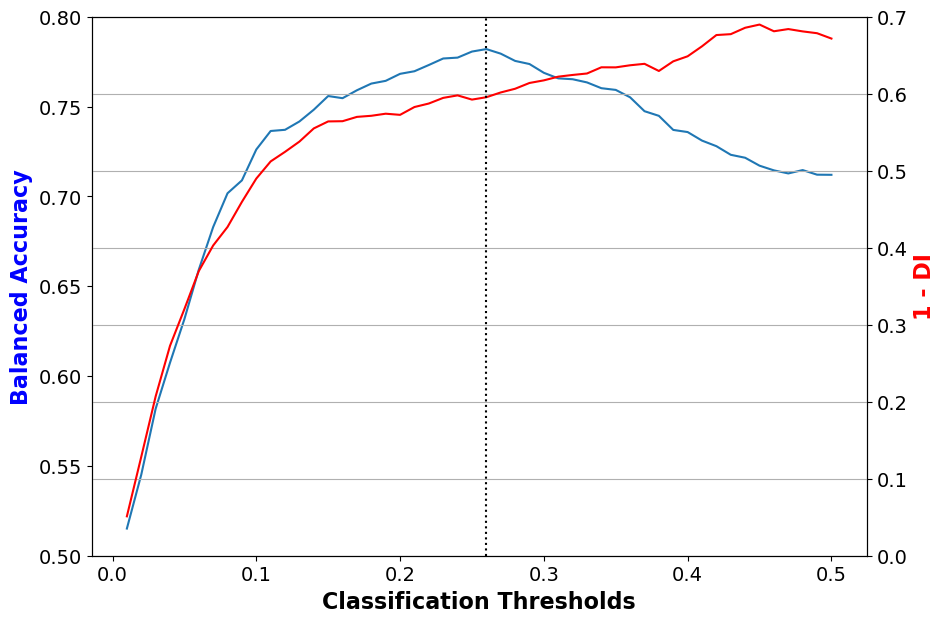

In [15]:
def plot(x:np.ndarray, x_name:str, y_left:np.ndarray, y_left_name:str, y_right:np.ndarray, y_right_name:str) -> None:
    '''
        Create a matplotlib plot with two y-axes and a single x-axis. 
    '''
    fig, ax1 = plt.subplots(figsize=(10,7)) # create a figure and axis
    ax1.plot(x, y_left) # plot the left y-axis data
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold') # set the x-axis label
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')  # set the left y-axis label
    ax1.xaxis.set_tick_params(labelsize=14) # set the x-axis tick label size
    ax1.yaxis.set_tick_params(labelsize=14) # set the left y-axis tick label size
    ax1.set_ylim(0.5, 0.8) # set the left y-axis limits

    ax2 = ax1.twinx() # create a second y-axis that shares the same x-axis
    ax2.plot(x, y_right, color='r') # plot the right y-axis data
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold') # set the right y-axis label
    if 'DI' in y_right_name: 
        ax2.set_ylim(0., 0.7) # set the right y-axis limits  if we're plotting disparate impact
    else:
        ax2.set_ylim(-0.25, 0.1)  # set the right y-axis limits if we're plotting 1-DI

    best_ind = np.argmax(y_left) # get the index of the best balanced accuracy
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':') # add a vertical line at the best balanced accuracy
    ax2.yaxis.set_tick_params(labelsize=14) # set the right y-axis tick label size
    ax2.grid(True) # add a grid
disp_imp = np.array(val_metrics['disp_imp']) # disparate impact (DI)
disp_imp_err = 1 - disp_imp # calculate 1 - DI
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - DI') # Plot balanced accuracy and 1-DI against the classification thresholds

:::::::::::::::::::::::::::::::::::::: challenge
### Interpreting the plot
Answer the following questions:
1. When the classification threshold is 0.1, what is the (approximate) accuracy and 1-DI score? What about when the classification threshold is 0.5? 
2. If you were developing the model, what classification threshold would you choose based on this graph? Why?
::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::: solution
### Solution
1. Using a threshold of 0.1, the accuracy is about 0.71 and the 1-DI score is about 0.71. Using a threshold of 0.5, the accuracy is about 0.69 and the 1-DI score is about 0.79.
2. The optimal accuracy occurs with a threshold of 0.19 (indicated by the dotted vertical line). However, the disparate impact is quite bad at this threshold. Choosing a slightly smaller threshold, e.g., around 0.15, yields similarly high-accuracy and is slightly fairer. However, there's no "good" outcome here: whenever the accuracy is near-optimal, the 1-DI score is high. If you were the model developer, you might want to consider interventions to improve the accuracy/fairness tradeoff, some of which we discuss below.
:::::::::::::::::::::::::

If you like, you can plot other metrics, e.g., average odds difference.

In the next cell, we write a function to print out a variety of other metrics. Instead of considering disparate impact directly, we will consider 1 - disparate impact. Recall that a disparate impact of 0 is very bad, and 1 is perfect -- thus, considering 1 - disparate impact means that 0 is perfect and 1 is very bad, similar to the other metrics we consider. **I.e., all of these metrics have a value of 0 if they are perfectly fair**. 

We print the value of several metrics here for illustrative purposes (i.e., to see that multiple metrics are not able to be optimized simultaneously). In practice, when evaluating a model it is typical ot choose a single fairness metric to use based on the details of the situation. You can learn more details about the various metrics in the [AIF360 documentation](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.metrics.ClassificationMetric.html#aif360.metrics.ClassificationMetric).

In [16]:
def describe_metrics(metrics: dict, thresh_arr: np.ndarray) -> None:
    '''
        Given a dictionary of metrics and a list of potential cutoff thresholds, print the best
        threshold (based on 'bal_acc' balanced accuracy dictionary entry) and the corresponding
        values of other metrics at the selected threshold.
    '''
    best_ind = np.argmax(metrics['bal_acc']) # get the index of the best balanced accuracy
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    disp_imp_at_best_ind = 1 - metrics['disp_imp'][best_ind] # calculate 1 - DI at the best index
    print("\nCorresponding 1-DI value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

describe_metrics(val_metrics, thresh_arr) # call the function

Threshold corresponding to Best balanced accuracy: 0.2600
Best balanced accuracy: 0.7820

Corresponding 1-DI value: 0.5955
Corresponding average odds difference value: -0.1725
Corresponding statistical parity difference value: -0.2178
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0912


### Test the model
Now that we have used the validation data to select the best threshold, we will evaluate the test the model on the test data.

In [17]:
lr_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]]) # call our function "test" with the test data and lr model
describe_metrics(lr_metrics, [thresh_arr[lr_orig_best_ind]]) # print the metrics for the test data

Threshold corresponding to Best balanced accuracy: 0.2600
Best balanced accuracy: 0.7659

Corresponding 1-DI value: 0.6399
Corresponding average odds difference value: -0.1816
Corresponding statistical parity difference value: -0.2292
Corresponding equal opportunity difference value: -0.2175
Corresponding Theil index value: 0.0992


## Mitigate bias with in-processing
We will use reweighting as an in-processing step to try to increase fairness. AIF360 has a function that performs reweighting that we will use. If you're interested, you can look at details about how it works in [the documentation](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.Reweighing.html). 

If you look at the documentation, you will see that AIF360 classifies reweighting as a preprocessing, not an in-processing intervention. Technically, AIF360's implementation modifies the dataset, not the learning algorithm so it is pre-processing. But, it is functionally equivalent to modifying the learning algorithm's loss function, so we follow the convention of the fair ML field and call it in-processing.

In [18]:
from aif360.algorithms.preprocessing import Reweighing

In [19]:
# Reweighting is a AIF360 class to reweight the data 
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups) # create a Reweighing object with the unprivileged and privileged groups
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train) # reweight the training data

We'll also define metrics for the reweighted data and print out the disparate impact of the dataset.

In [20]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train, # use train data
        unprivileged_groups=unprivileged_groups, # pass in unprivileged and privileged groups
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train) # create a MetricTextExplainer object

print(explainer_transf_panel19_train.disparate_impact()) # print disparate impact

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


Then, we'll train a model, validate it, and evaluate of the test data.

In [21]:
# train
dataset = dataset_transf_panel19_train  # use the reweighted training data
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1)) # model pipeline
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params) # fit the model


In [22]:
# validate
thresh_arr = np.linspace(0.01, 0.5, 50) # check 50 thresholds between 0.01 and 0.5
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr) # call our function "test" with the validation data and lr model
lr_transf_best_ind = np.argmax(val_metrics['bal_acc']) # get the index of the best balanced accuracy

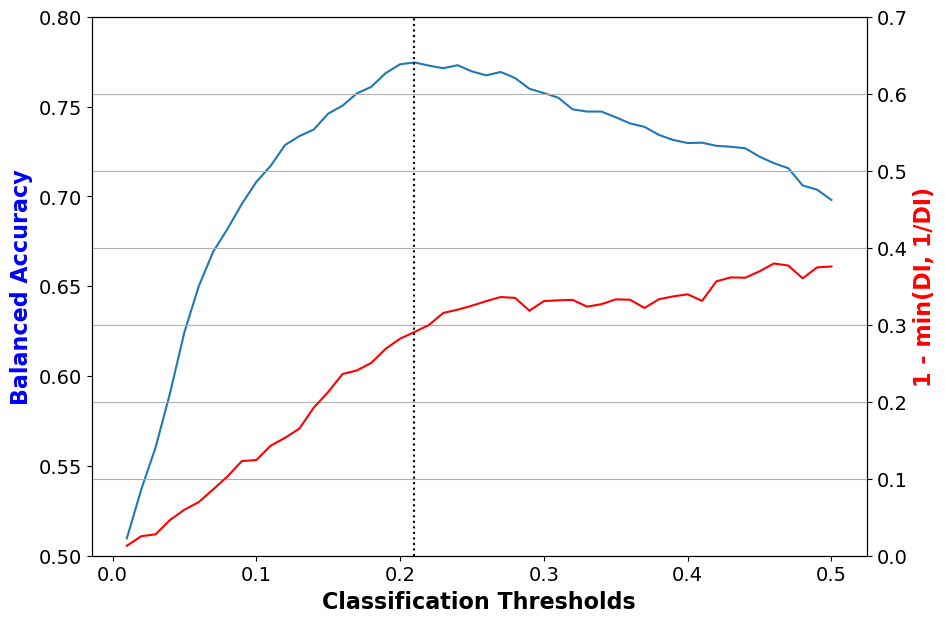

In [23]:
# plot validation results
disp_imp = np.array(val_metrics['disp_imp']) # get the disparate impact values
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp) # calculate 1 - min(DI, 1/DI)
plot(thresh_arr, # use the classification thresholds as the x-axis
     'Classification Thresholds', 
     val_metrics['bal_acc'],  # plot accuracy on the first y-axis
     'Balanced Accuracy', 
     disp_imp_err, # plot 1 - min(DI, 1/DI) on the second y-axis
     '1 - min(DI, 1/DI)'
     )

In [24]:
describe_metrics(val_metrics, thresh_arr) # describe validation results

Threshold corresponding to Best balanced accuracy: 0.2100
Best balanced accuracy: 0.7746

Corresponding 1-DI value: 0.2905
Corresponding average odds difference value: -0.0461
Corresponding statistical parity difference value: -0.1058
Corresponding equal opportunity difference value: -0.0763
Corresponding Theil index value: 0.0910


### Test

In [25]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]]) # call our function "test" with the test data and lr model
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]]) # describe test results

Threshold corresponding to Best balanced accuracy: 0.2100
Best balanced accuracy: 0.7711

Corresponding 1-DI value: 0.3056
Corresponding average odds difference value: -0.0233
Corresponding statistical parity difference value: -0.1081
Corresponding equal opportunity difference value: -0.0086
Corresponding Theil index value: 0.0929


We see that the disparate impact score on the test data is better after reweighting than it was originally.

How do the other fairness metrics compare?

## Mitigate bias with preprocessing
We will use a method, [ThresholdOptimizer](https://fairlearn.org/main/api_reference/generated/fairlearn.postprocessing.ThresholdOptimizer.html#fairlearn.postprocessing.ThresholdOptimizer), that is implemented in the library [Fairlearn](https://fairlearn.org/). ThresholdOptimizer finds custom thresholds for each demographic group so as to achieve parity in the desired group fairness metric.

We will focus on demographic parity, but feel free to try other metrics if you're curious on how it does.

The first step is creating the ThresholdOptimizer object. We pass in the demographic parity constraint, and indicate that we would like to optimize the balanced accuracy score (other options include accuracy, and true or false positive rate -- see [the documentation](https://fairlearn.org/main/api_reference/generated/fairlearn.postprocessing.ThresholdOptimizer.html#fairlearn.postprocessing.ThresholdOptimizer) for more details). 

In [26]:
from fairlearn.postprocessing import ThresholdOptimizer # import ThresholdOptimizer

In [27]:
# create a ThresholdOptimizer object
to = ThresholdOptimizer(estimator=model, 
                        constraints="demographic_parity", # set the constraint to demographic parity
                        objective="balanced_accuracy_score", # optimize for balanced accuracy
                        prefit=True) 

Next, we fit the ThresholdOptimizer object to the validation data.

In [28]:
to.fit(dataset_orig_panel19_val.features, dataset_orig_panel19_val.labels, 
       sensitive_features=dataset_orig_panel19_val.protected_attributes[:,0]) # fit the ThresholdOptimizer object

/Users/annameyer/miniforge3/envs/trustworthy_ML/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:288: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(random_state=1,
                                                                 solver='liblinear'))]),
                   objective='balanced_accuracy_score', prefit=True)

Then, we'll create a helper function, `mini_test` to allow us to call the `describe_metrics` function even though we are no longer evaluating our method as a variety of thresholds.

After that, we call the ThresholdOptimizer's predict function on the validation and test data, and then compute metrics and print the results.

In [29]:
def mini_test(dataset:MEPSDataset19, preds:np.ndarray) -> dict:
    '''
        Given a dataset and predictions, compute various metrics for the model. Returns a dictionary of the metrics,
        including balanced accuracy, average odds difference, disparate impact, statistical parity difference, equal
        opportunity difference, and theil index.
    '''
    metric_arrs = defaultdict(list)
    dataset_pred = dataset.copy()
    dataset_pred.labels = preds
    metric = ClassificationMetric(
            dataset, dataset_pred,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)

    # various metrics - can look up what they are on your own
    metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                    + metric.true_negative_rate()) / 2)
    metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
    metric_arrs['disp_imp'].append(metric.disparate_impact())
    metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
    metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
    metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [30]:
# get predictions for validation dataset using the ThresholdOptimizer
to_val_preds = to.predict(dataset_orig_panel19_val.features, 
                          sensitive_features=dataset_orig_panel19_val.protected_attributes[:,0])

# get predictions for test dataset using the ThresholdOptimizer
to_test_preds = to.predict(dataset_orig_panel19_test.features, 
                           sensitive_features=dataset_orig_panel19_test.protected_attributes[:,0])

In [31]:
to_val_metrics = mini_test(dataset_orig_panel19_val, to_val_preds) # compute metrics for the validation set
to_test_metrics = mini_test(dataset_orig_panel19_test, to_test_preds) # compute metrics for the test set

In [32]:
print("Remember, `Threshold corresponding to Best balanced accuracy` is just a placeholder here.")
describe_metrics(to_val_metrics, [0]) # check accuracy (ignore other metrics for now)

Remember, `Threshold corresponding to Best balanced accuracy` is just a placeholder here.
Threshold corresponding to Best balanced accuracy: 0.0000
Best balanced accuracy: 0.6893

Corresponding 1-DI value: 0.0237
Corresponding average odds difference value: 0.0410
Corresponding statistical parity difference value: -0.0038
Corresponding equal opportunity difference value: 0.0226
Corresponding Theil index value: 0.1243


In [33]:
print("Remember, `Threshold corresponding to Best balanced accuracy` is just a placeholder here.")

describe_metrics(to_test_metrics, [0]) # check accuracy (ignore other metrics for now)

Remember, `Threshold corresponding to Best balanced accuracy` is just a placeholder here.
Threshold corresponding to Best balanced accuracy: 0.0000
Best balanced accuracy: 0.6477

Corresponding 1-DI value: 0.0200
Corresponding average odds difference value: 0.0461
Corresponding statistical parity difference value: -0.0028
Corresponding equal opportunity difference value: 0.0560
Corresponding Theil index value: 0.1389


Scroll up and see how these results compare with the original classifier and with the in-processing technique. 

A major difference is that the accuracy is lower, now. In practice, it might be better to use an algorithm that allows a custom tradeoff between the accuracy sacrifice and increased levels of fairness.

We can also see what threshold is being used for each demographic group by examining the `interpolated_thresholder_.interpretation_dict` property of the ThresholdOptimzer.

In [34]:
threshold_rules_by_group = to.interpolated_thresholder_.interpolation_dict # get the threshold rules by group
threshold_rules_by_group # print the threshold rules by group

{0.0: {'p0': 0.9326678726483357,
  'operation0': [>0.5],
  'p1': 0.06733212735166427,
  'operation1': [>-inf]},
 1.0: {'p0': 0.9996584852734923,
  'operation0': [>0.5],
  'p1': 0.00034151472650767456,
  'operation1': [>-inf]}}

Recall that a value of 1 in the Race column corresponds to White people, while a value of 0 corresponds to non-White people.

Due to the inherent randomness of the ThresholdOptimizer, you might get slightly different results than your neighbors. When we ran the previous cell, the output was

`
{0.0: {'p0': 0.9287205987170348,
  'operation0': [>0.5],
  'p1': 0.07127940128296517,
  'operation1': [>-inf]},
 1.0: {'p0': 0.002549618320610717,
  'operation0': [>inf],
  'p1': 0.9974503816793893,
  'operation1': [>0.5]}}
`

This tells us that for non-White individuals:

* If the score is above 0.5, predict 1. 

* Otherwise, predict 1 with probability 0.071

And for White individuals:

* If the score is above 0.5, predict 1 with probability 0.997



**Discussion question:** what are the pros and cons of improving the model fairness by introducing randomization?